# Facebook Recommendation System 

In [ ]:
#import the necessary library
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb
import time
import lightgbm as lgb
import warnings
import networkx as nx
import pdb
import pickle
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
import time
import lightgbm as lgb
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"karthicktj","key":"0fdf4475e2fad32a54bb9eea38c4bbf2"}'}

In [ ]:
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d karthicktj/test-pos-data

 67% 9.00M/13.4M [00:00<00:00, 24.4MB/s]
100% 13.4M/13.4M [00:00<00:00, 30.3MB/s]


In [ ]:
!kaggle datasets download -d karthicktj/finalsample

 88% 65.0M/73.8M [00:02<00:00, 33.7MB/s]
100% 73.8M/73.8M [00:02<00:00, 34.9MB/s]


In [ ]:
!kaggle datasets download -d karthicktj/train-test-facebook-clean-data

 97% 130M/134M [00:04<00:00, 37.7MB/s]
100% 134M/134M [00:04<00:00, 34.6MB/s]


In [ ]:
!kaggle datasets download -d karthicktj/train-pos-after-eda-facebook

 95% 121M/128M [00:03<00:00, 42.3MB/s]
100% 128M/128M [00:03<00:00, 38.8MB/s]


In [ ]:
import zipfile 

storage_sample = zipfile.ZipFile("/content/finalsample.zip",'r')
storage_sample.extractall('storage_sample_stage4')
storage_sample.close()

train_pos_after_eda = zipfile.ZipFile('/content/train-pos-after-eda-facebook.zip','r')
train_pos_after_eda.extractall('train_pos')
train_pos_after_eda.close()


test_pos_after_eda = zipfile.ZipFile("/content/test-pos-data.zip",'r')
test_pos_after_eda.extractall('test_pos')
test_pos_after_eda.close()


In [ ]:
#import the cleaned data 
train_data = pd.read_hdf("/content/storage_sample_stage4/storage_sample_stage4.h5",'train_df',mode = 'r')
test_data = pd.read_hdf("/content/storage_sample_stage4/storage_sample_stage4.h5",'test_df',mode = 'r')

In [ ]:
if os.path.isfile('/content/train_pos/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('/content/train_pos/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))

DiGraph with 1780722 nodes and 7550015 edges


In [ ]:
if  os.path.isfile("/content/test_pos/test_pos_after_eda.csv"):
    test_graph = nx.read_edgelist('/content/test_pos/test_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(test_graph))

DiGraph with 1144623 nodes and 1887504 edges


# Common Neighbour

Reference_paper : https://www.researchgate.net/publication/330357572_Review_on_Learning_and_Extracting_Graph_Features_for_Link_Prediction
Reference : https://neo4j.com/docs/graph-data-science/current/alpha-algorithms/common-neighbors/#:~:text=Common%20Neighbors%20This%20section%20describes%20the%20Common%20Neighbors,common.%20This%20algorithm%20is%20in%20the%20alpha%20tier.



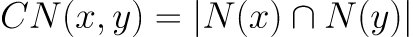
where N(x) is the set of nodes adjacent to node x, and N(y) is the set of nodes adjacent to node y

In [ ]:
def common_neighbour(source_node,destination_node,graph):
    try: 
        if len(set(graph.predecessors(source_node))) == 0 or len(set(graph.predecessors(destination_node))) == 0:
            return 0
        
        node_a_neighbours = set(graph.predecessors(source_node))
        node_b_neighbours = set(graph.predecessors(destination_node))
        common_neighbours = len(node_a_neighbours.intersection(node_b_neighbours))
    except:
        return 0 
    
    return common_neighbours

In [ ]:
def common_neighbour_followee(source_node,destination_node,graph):
    try: 
        if len(set(graph.successors(source_node))) == 0 or len(set(graph.successors(destination_node))) == 0:
            return 0
        
        node_a_neighbours = set(graph.successors(source_node))
        node_b_neighbours = set(graph.successors(destination_node))
        common_neighbours = len(node_a_neighbours.successors(node_b_neighbours))
    except:
        return 0 
    
    return common_neighbours

## Sørensen Index

The difference in using the summation of the degrees instead of the size of the union of their neighbors makes SI less
outlier sensitive when compared to JC

In [ ]:
def sorensen_index_followers(source,destination,graph):
    source_set,destination_set = 0,0
    sorensen_index_follower = 0.0
    try:
        if len(set(graph.predecessors(source))) == 0 or len(set(graph.predecessors(destination))) == 0:
            return 0
        
        source_set = set(graph.predecessors(source))
        
        destination_set = set(graph.predecessors(destination))
        
        sorensen_index_follower = source_set.intersection(destination_set) / (len(source_set)+ len(destination_set))
        
    except:
        return 0
                                                                            
    return sorensen_index_followers
                                                                               
        
    

In [ ]:
def sorensen_index_followeee(source,destination,graph):
    source_set,destination_set = 0,0
    sorensen_index_followee = 0.0
    try:
        if len(set(graph.successors(source))) == 0 or len(set(graph.successors(destination))) == 0:
            return 0
        
        source_set = set(graph.successors(source))
        
        destination_set = set(graph.successors(destination))
        
        sorensen_index_followee = source_set.intersection(destination_set) / (len(source_set)+ len(destination_set))
        
    except:
        return 0
                                                                            
    return sorensen_index_followee
                                                                               

## Preferential_attachement

In [ ]:
def preferential_attachement_followee(source,destination,graph):
    
    source_set,destination_set = 0,0
    pre_att_followers = 0
    try:
        if len(set(graph.predecessors(source))) == 0 or len(set(graph.predecessors(destination))) == 0:
            return 0
        
        source_set = set(graph.predecessors(source))
        
        destination_set = set(graph.predecessors(destination))
        
        pre_att_followers = source_set * destination_set 
        
    except:
        return 0    
    return pre_att_followers
        

In [ ]:
def preferential_attachement_followers(source,destination,graph):
    
    source_set,destination_set = 0,0
    pre_att_followers = 0
    try:
        if len(set(graph.successors(source))) == 0 or len(set(graph.successors(destination))) == 0:
            return 0
        
        source_set = set(graph.successors(source))
        
        destination_set = set(graph.successors(destination))
        
        pre_att_followers = source_set * destination_set 
        
    except:
        return 0    
    return pre_att_followers
        

In [ ]:
train_data['common_neighbour_follwer'] = train_data.apply(lambda row :common_neighbour(row['source_node'],row['destination_node'],train_graph),axis = 1)
test_data['common_neighbour_follwer'] = test_data.apply(lambda row :common_neighbour(row['source_node'],row['destination_node'],test_graph),axis = 1)

In [ ]:
train_data['common_neighbour_followee'] = train_data.apply(lambda row :common_neighbour_followee(row['source_node'],row['destination_node'],train_graph),axis = 1)
test_data['common_neighbour_followee'] = test_data.apply(lambda row :common_neighbour_followee(row['source_node'],row['destination_node'],test_graph),axis = 1)

In [ ]:
train_data["SI_followers"] = train_data.apply(lambda row :sorensen_index_followers(row['source_node'],row['destination_node'],train_graph),axis = 1)
test_data["SI_followers"] = test_data.apply(lambda row :sorensen_index_followers(row['source_node'],row['destination_node'],test_graph),axis = 1)

In [ ]:
train_data["SI_followeee"] = train_data.apply(lambda row :sorensen_index_followeee(row['source_node'],row['destination_node'],train_graph),axis = 1)
test_data["SI_followeee"] = test_data.apply(lambda row :sorensen_index_followeee(row['source_node'],row['destination_node'],test_graph),axis = 1)

In [ ]:
train_data['pre_att_followee'] = train_data.apply(lambda row: preferential_attachement_followee(row['source_node'],row['destination_node'],train_graph),axis = 1)
test_data['pre_att_followee'] = test_data.apply(lambda row: preferential_attachement_followee(row['source_node'],row['destination_node'],test_graph),axis = 1)

In [ ]:
train_data['pre_att_followers'] = train_data.apply(lambda row: preferential_attachement_followers(row['source_node'],row['destination_node'],train_graph),axis = 1)
test_data['pre_att_followers'] = test_data.apply(lambda row: preferential_attachement_followers(row['source_node'],row['destination_node'],test_graph),axis = 1)


### Resource Allocation Index

Resource Allocation defined as inverted sum of degrees of common neighbours for given two vertices.
$$RAI(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{|N(u)|)}$$

Resource Allocation is Similar to Adar Index.The Main Difference between Resource Allocation and Adar Index is Instead of Tasking log of the neighbour we directly using the length of the set

In [ ]:
def resource_allocation(a,b,graph):
    sum=0
    try:
        n=list(set(graph.successors(a)).intersection(set(graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/len(list(train_graph.predecessors(i))))
            return sum
        else:
            return 0
    except:
        return 0

#### HUB Promoted Index
HP is determined by the ratio of the number of common neighbors of both vx and vy to the minimum of degrees of vx
and vy

In [121]:
def hub_promoted_index_followee(source,destination,graph):
    source_set,destination_set = 0,0
    hub_promoted_index_followee = 0.0
    try:
        if len(set(graph.successors(source))) == 0 or len(set(graph.successors(destination))) == 0:
            return 0
        
        source_set = set(graph.successors(source))
        
        destination_set = set(graph.successors(destination))
        
        hub_promoted_index_followee = source_set.intersection(destination_set) / min(len(source_set), len(destination_set))
        
    except:
        return 0
                                                                            
    return hub_promoted_index_followee

In [122]:
def hub_promoted_index_followers(source,destination,graph):
    source_set,destination_set = 0,0
    hub_promoted_index_followers = 0.0
    try:
        if len(set(graph.predecessors(source))) == 0 or len(set(graph.predecessors(destination))) == 0:
            return 0
        
        source_set = set(graph.predecessors(source))
        
        destination_set = set(graph.predecessors(destination))
        
        hub_promoted_index_followers = source_set.intersection(destination_set) / min(len(source_set), len(destination_set))
        
    except:
        return 0
                                                                            
    return hub_promoted_index_followers

In [ ]:
def svd_dot_u_product(data):
    svd_dot_followers = 0
    for i in range(1,7): 
        svd_dot_followers += data['svd_u_s_'+ str(i)] * data['svd_u_d_'+str(i)]
    return svd_dot_followers
    
    

In [ ]:
def svd_v_dot_product(data):
    svd_dot_followee = 0
    for i in range(1,7):
        svd_dot_followee += data['svd_v_s_' + str(i)] * data['svd_v_d_'+str(i)]
    return svd_dot_followee

In [ ]:
train_data['svd_u_dot'] = train_data.apply(lambda row :svd_dot_u_product(row),axis = 1)
test_data['svd_u_dot'] = test_data.apply(lambda row : svd_dot_u_product(row),axis = 1)

In [ ]:
train_data['svd_v_dot'] = train_data.apply(lambda row :svd_v_dot_product(row),axis = 1)
test_data['svd_v_dot'] = test_data.apply(lambda row : svd_v_dot_product(row),axis = 1)

In [123]:
train_data['hub_promoted_index_followers'] = train_data.apply(lambda row :hub_promoted_index_followers(row['source_node'],row['destination_node'],train_graph),axis = 1)
test_data['hub_promoted_index_followers'] = test_data.apply(lambda row :hub_promoted_index_followers(row['source_node'],row['destination_node'],test_graph),axis = 1)
train_data['hub_promoted_index_followee'] = train_data.apply(lambda row :hub_promoted_index_followee(row['source_node'],row['destination_node'],train_graph),axis = 1)
test_data['hub_promoted_index_followee'] = test_data.apply(lambda row :hub_promoted_index_followee(row['source_node'],row['destination_node'],test_graph),axis = 1)

In [ ]:
train_data['resource_allocation'] = train_data.apply(lambda row :resource_allocation(row['source_node'],row['destination_node'],train_graph),axis = 1)
test_data['resource_allocation'] = test_data.apply(lambda row : resource_allocation(row['source_node'],row['destination_node'],test_graph),axis = 1)

In [ ]:
y_train =train_data['indicator_link']
y_test = test_data['indicator_link']

In [ ]:
x_train = train_data.drop(columns = ['source_node','destination_node','indicator_link'],axis = 1)
x_test = test_data.drop(columns = ['source_node','destination_node','indicator_link'],axis = 1)

In [ ]:
print("Shape of the train:{0} and the train_data y {1}".format(x_train.shape,y_train.shape))

Shape of the train:(100002, 60) and the train_data y (100002,)


# Random Forest Classifier

Estimators =  10 Train Score 0.9217564787298156 test Score 0.9120093879005049
Estimators =  50 Train Score 0.9211333506628542 test Score 0.9003218157181572
Estimators =  100 Train Score 0.9174375287765268 test Score 0.8771366594360088
Estimators =  250 Train Score 0.9210364037333947 test Score 0.8917735913830838
Estimators =  450 Train Score 0.9215426226255496 test Score 0.9082497095172706


Text(0, 0.5, 'Score')

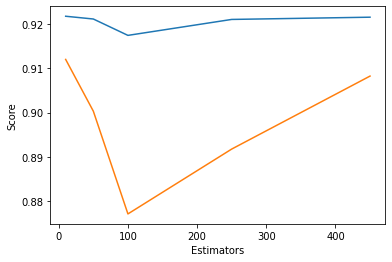

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

#hyper
estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(x_train,y_train)
    train_sc = f1_score(y_train,clf.predict(x_train))
    test_sc = f1_score(y_test,clf.predict(x_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')

depth =  3 Train Score 0.8539938399459117 test Score 0.8404664191257899
depth =  9 Train Score 0.9405988692389586 test Score 0.9203800855403157
depth =  11 Train Score 0.9566351749370675 test Score 0.9185648480750539
depth =  15 Train Score 0.9558810040664079 test Score 0.9226947368421053
depth =  20 Train Score 0.9586963372607225 test Score 0.918758982162482
depth =  35 Train Score 0.9586751654518284 test Score 0.915993982923367
depth =  50 Train Score 0.9586751654518284 test Score 0.915993982923367
depth =  70 Train Score 0.9586751654518284 test Score 0.915993982923367
depth =  130 Train Score 0.9586751654518284 test Score 0.915993982923367


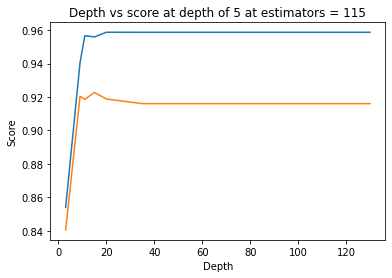

In [ ]:
best_estimator = 50
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=70, min_samples_split = 200,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(x_train,y_train)
    train_sc = f1_score(y_train,clf.predict(x_train))
    test_sc = f1_score(y_test,clf.predict(x_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

# Hyper Parameter tuning for Lgbm Classifier

Estimators =  10 Train Score 0.9716947549353647 test Score 0.9343950659006421
Estimators =  20 Train Score 0.9729790084859312 test Score 0.9339696349008594
Estimators =  30 Train Score 0.9755505427030965 test Score 0.9338337620714376
Estimators =  50 Train Score 0.9779195091430186 test Score 0.9293502424152605
Estimators =  60 Train Score 0.979581135994676 test Score 0.9288497374216499
Estimators =  70 Train Score 0.9810651483851462 test Score 0.9290825183115289
Estimators =  80 Train Score 0.9822939328015471 test Score 0.9291051885094943
Estimators =  90 Train Score 0.983308836853444 test Score 0.9292929292929292
Estimators =  100 Train Score 0.9842819191756562 test Score 0.9292552740828602
Estimators =  150 Train Score 0.9890950716953849 test Score 0.9282002333227279
Estimators =  200 Train Score 0.992860580779721 test Score 0.927328296120214
Estimators =  300 Train Score 0.9979595102824678 test Score 0.9263014688689071
Estimators =  400 Train Score 0.9995802518488907 test Score 0.92

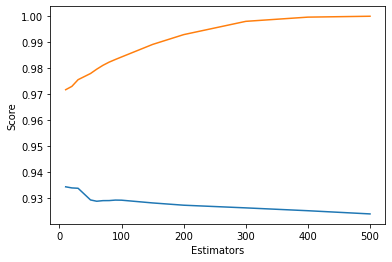

In [ ]:
%%time 
import time
import lightgbm as lgb
train_scores = []
test_scores = []
#hyper param tuning 
start_time = time.time()
n_estimators=[10,20,30,50,60,70,80,90,100,150,200,300,400,500]
for estimator in n_estimators:
    
    lgbm  = lgb.LGBMClassifier(learning_rate=0.1,n_estimators = estimator,max_depth= -1,random_state=314, silent=True, metric='None', n_jobs=4,
                         min_child_samples = 100,reg_alpha = 1e-1 , reg_lambda = 1e-1)
    lgbm.fit(x_train, y_train)
    train_pred = lgbm.predict(x_train)
    train_f1_score = f1_score(y_train,train_pred)
    test_pred =lgbm.predict(x_test)
    test_f1_score = f1_score(y_test,test_pred)
    test_scores.append(train_f1_score)
    train_scores.append(test_f1_score)
    
    print('Estimators = ',estimator,'Train Score',train_f1_score,'test Score',test_f1_score)
print("Time Estimate : {0}".format(time.time() - start_time))
plt.plot(n_estimators,train_scores,label='Train Score')
plt.plot(n_estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')

# Hyper param Tuning with depth

depth =  3 Train Score 0.9832949018739112 test Score 0.9005226480836237
depth =  9 Train Score 0.9998701130016886 test Score 0.923598379876359
depth =  11 Train Score 0.9999400563470339 test Score 0.923896142622846
depth =  15 Train Score 0.9999700290718003 test Score 0.9254010808970595
depth =  20 Train Score 0.9999600383631714 test Score 0.9248845277878291
depth =  35 Train Score 0.9999500474549178 test Score 0.9247206555283601
depth =  50 Train Score 0.9999500474549178 test Score 0.9247206555283601
depth =  70 Train Score 0.9999500474549178 test Score 0.9247206555283601
depth =  130 Train Score 0.9999500474549178 test Score 0.9247206555283601


Text(0, 0.5, 'Score')

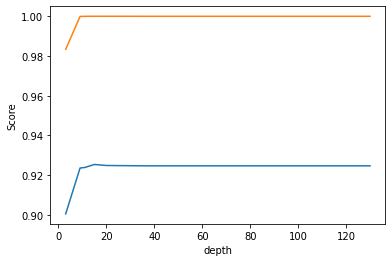

In [ ]:
import lightgbm as lgb
train_scores = []
test_scores = []
#hyper param tuning 
depths=[3,9,11,15,20,35,50,70,130]
for depth in depths:
    
    lgbm  = lgb.LGBMClassifier(learning_rate=0.1,n_estimators = 500,max_depth= depth,random_state=314, silent=True, metric='None', n_jobs=4,
                         min_child_samples = 20,reg_alpha = 0.1 , reg_lambda = 0.1)
    lgbm.fit(x_train, y_train)
    train_pred = lgbm.predict(x_train)
    train_f1_score = f1_score(y_train,train_pred)
    test_pred =lgbm.predict(x_test)
    test_f1_score = f1_score(y_test,test_pred)
    test_scores.append(train_f1_score)
    train_scores.append(test_f1_score)
    
    print('depth = ',depth,'Train Score',train_f1_score,'test Score',test_f1_score)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('depth')
plt.ylabel('Score')

# Hyper param Tuning with Learning Rate

Learning Rate  =  0.0001 Train Score 0.9706818460031829 test Score 0.9351215281450298
Learning Rate  =  0.001 Train Score 0.9709945455472294 test Score 0.9341826800981969
Learning Rate  =  0.01 Train Score 0.9781873605797863 test Score 0.929357953582924
Learning Rate  =  0.1 Train Score 0.9999600383631714 test Score 0.9248845277878291
Learning Rate  =  0.2 Train Score 1.0 test Score 0.9206539160166685
Learning Rate  =  0.3 Train Score 1.0 test Score 0.919796389768158
CPU times: user 4min 11s, sys: 12.5 s, total: 4min 24s
Wall time: 2min 26s


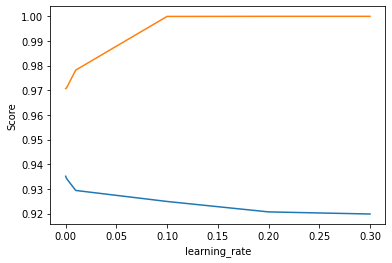

In [ ]:
%%time
train_scores = []
test_scores = []
#hyper param tuning 
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
for lr in learning_rate:
    
    lgbm  = lgb.LGBMClassifier(learning_rate=lr,n_estimators = 500,max_depth= 20,random_state=314, silent=True, metric='None', n_jobs=4,
                         min_child_samples = 20,reg_alpha = 0.1 , reg_lambda = 0.1)
    lgbm.fit(x_train, y_train)
    train_pred = lgbm.predict(x_train)
    train_f1_score = f1_score(y_train,train_pred)
    test_pred =lgbm.predict(x_test)
    test_f1_score = f1_score(y_test,test_pred)
    test_scores.append(train_f1_score)
    train_scores.append(test_f1_score)
    
    print('Learning Rate  = ',lr,'Train Score',train_f1_score,'test Score',test_f1_score)
plt.plot(learning_rate,train_scores,label='Train Score')
plt.plot(learning_rate,test_scores,label='Test Score')
plt.xlabel('learning_rate')
plt.ylabel('Score')

 Alpha  =  0 Train Score 0.9706818460031829 test Score 0.9351215281450298
 Alpha  =  0.1 Train Score 0.9706818460031829 test Score 0.9351215281450298
 Alpha  =  1 Train Score 0.9706818460031829 test Score 0.9351215281450298
 Alpha  =  2 Train Score 0.9708538211729734 test Score 0.9350336760762621
 Alpha  =  5 Train Score 0.9706877113866967 test Score 0.9326539561885272
 Alpha  =  7 Train Score 0.9703644896441528 test Score 0.9329583333333332
 Alpha  =  10 Train Score 0.9705534033200185 test Score 0.9328727787257065
 Alpha  =  50 Train Score 0.968091001601999 test Score 0.9290481869729876
 Alpha  =  100 Train Score 0.947678174118998 test Score 0.9224469224469225
CPU times: user 5min 20s, sys: 15.6 s, total: 5min 35s
Wall time: 3min 5s


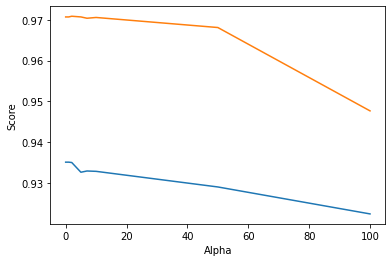

In [ ]:
%%time
train_scores = []
test_scores = []
best_learning_rate = 0.0001
max_depth = 20,
best_estimators = 500
#hyper param tuning 
reg_alpha =  [0, 1e-1, 1, 2, 5, 7, 10, 50, 100]
for alpha in reg_alpha:
    
    lgbm  = lgb.LGBMClassifier(learning_rate=best_learning_rate,n_estimators =best_estimators ,max_depth= max_depth,random_state=314, silent=True, metric='None', n_jobs=4,
                         min_child_samples = 20,reg_alpha = alpha , reg_lambda = 0.1)
    lgbm.fit(x_train, y_train)
    train_pred = lgbm.predict(x_train)
    train_f1_score = f1_score(y_train,train_pred)
    test_pred =lgbm.predict(x_test)
    test_f1_score = f1_score(y_test,test_pred)
    test_scores.append(train_f1_score)
    train_scores.append(test_f1_score)
    
    print(' Alpha  = ',alpha,'Train Score',train_f1_score,'test Score',test_f1_score)
plt.plot(reg_alpha,train_scores,label='Train Score')
plt.plot(reg_alpha,test_scores,label='Test Score')
plt.xlabel('Alpha')
plt.ylabel('Score')

 lambda  =  0 Train Score 0.9709020862847417 test Score 0.9344106262822819
 lambda  =  0.1 Train Score 0.97095156555773 test Score 0.9343655477293399
 lambda  =  1 Train Score 0.9708625064970802 test Score 0.9345205363563301
 lambda  =  2 Train Score 0.9715912557193696 test Score 0.935005171722289
 lambda  =  5 Train Score 0.9715732324772769 test Score 0.9348078424751495
 lambda  =  7 Train Score 0.9723360240133045 test Score 0.9344286466561349
 lambda  =  10 Train Score 0.9719781500511792 test Score 0.9351135407905803
 lambda  =  50 Train Score 0.9706392782113606 test Score 0.9327263530601921
 lambda  =  100 Train Score 0.9652473355609373 test Score 0.9263090812533191
CPU times: user 5min 24s, sys: 16 s, total: 5min 40s
Wall time: 3min 7s


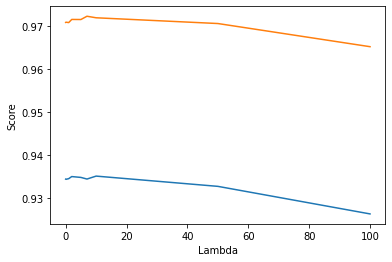

In [ ]:
%%time
train_scores = []
test_scores = []
best_learning_rate = 0.001
max_depth = 20,
best_estimators = 500
alpha = 1
reg_lambda = []
#hyper param tuning 
reg_lambda =  [0, 1e-1, 1, 2, 5, 7, 10, 50, 100]
for lamb in reg_alpha:
    
    lgbm  = lgb.LGBMClassifier(learning_rate=best_learning_rate,n_estimators =best_estimators ,max_depth= max_depth,random_state=314, silent=True, metric='None', n_jobs=4,
                         min_child_samples = 20,reg_alpha = alpha , reg_lambda = lamb)
    lgbm.fit(x_train, y_train)
    train_pred = lgbm.predict(x_train)
    train_f1_score = f1_score(y_train,train_pred)
    test_pred =lgbm.predict(x_test)
    test_f1_score = f1_score(y_test,test_pred)
    test_scores.append(train_f1_score)
    train_scores.append(test_f1_score)
    
    print(' lambda  = ',lamb,'Train Score',train_f1_score,'test Score',test_f1_score)
plt.plot(reg_lambda,train_scores,label='Train Score')
plt.plot(reg_lambda,test_scores,label='Test Score')
plt.xlabel('Lambda')
plt.ylabel('Score')

In [115]:
lgdm_best = lgb.LGBMClassifier(learning_rate=0.001,n_estimators =500 ,max_depth= 30,random_state=314, silent=True, metric='None', n_jobs=4,
                         min_child_samples = 200,reg_alpha = 0.1 , reg_lambda = 0.1)
lgdm_best.fit(x_train,y_train)
train_pred = lgdm_best.predict(x_train)
test_pred = lgdm_best.predict(x_test)
train_fl_score = f1_score(y_train,train_pred)
test_f1_score = f1_score(y_test,test_pred)
print("Train F1 Score : {0}".format(train_f1_score))
print("Test F1 Score : {0}".format(test_f1_score))

Train F1 Score : 0.9784861364096336
Test F1 Score : 0.9347926947572652


In [ ]:

def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("#2ecc71")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

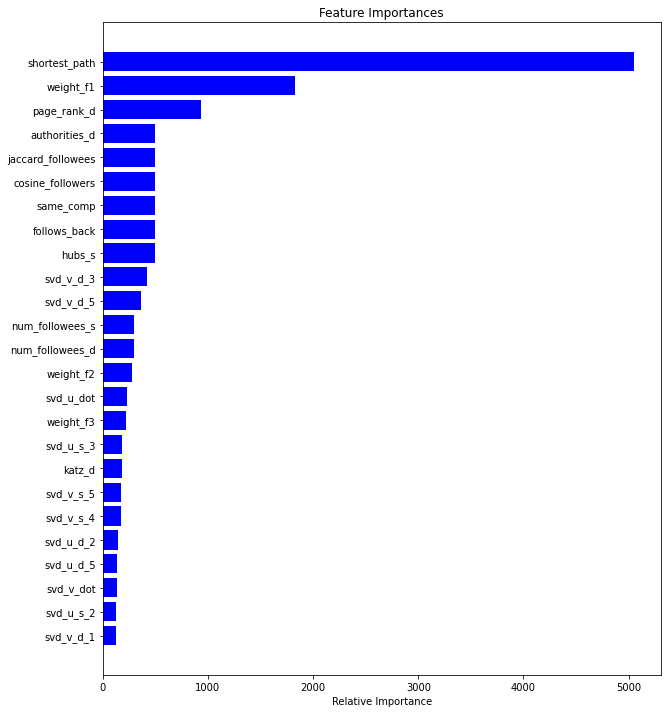

In [118]:
features = x_train.columns
#important Feature
importances = lgdm_best.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Train confusion_matrix


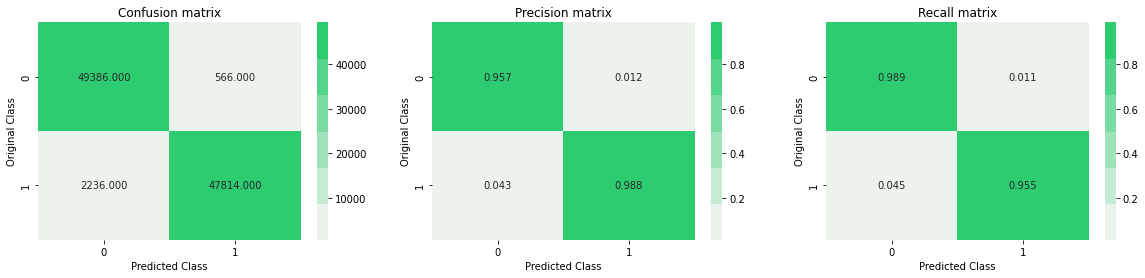

Test confusion_matrix


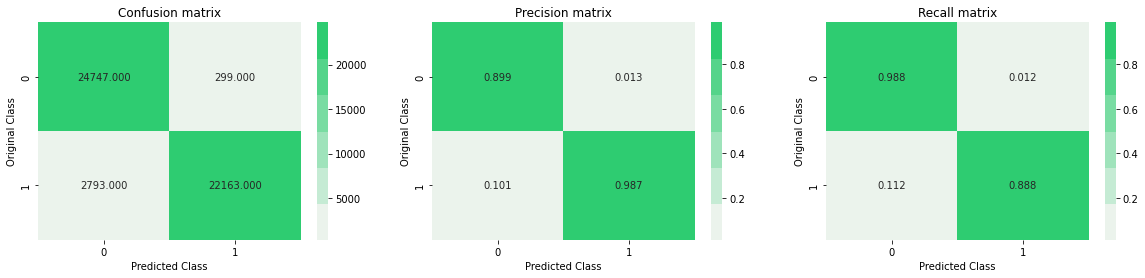

In [116]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,test_pred)

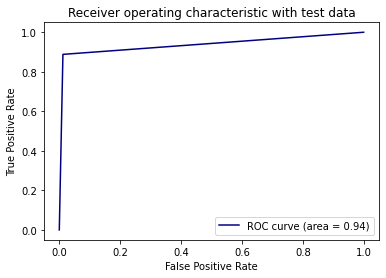

In [117]:
fpr,tpr,ths = roc_curve(y_test,test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

### Observation
1.To Build  Model GBDT algorithm Using LGBM we got Auc Score as 0.94

2.As We see the Feature Important Shortest Path is the Most Important Features,weight Feature is 2nd Important Feature

# XGBoost Model

Estimators =  10 Train Score 0.9989708336247639 test Score 0.9322752655666121
Estimators =  20 Train Score 0.9996803643846016 test Score 0.9337652230612287
Estimators =  30 Train Score 0.9998501723018529 test Score 0.9337515525335243
Estimators =  50 Train Score 0.9999800203792133 test Score 0.9328977871443626
Estimators =  60 Train Score 0.9999900100898093 test Score 0.9325880615903817
Estimators =  70 Train Score 1.0 test Score 0.9286606670195872
Estimators =  80 Train Score 1.0 test Score 0.9283565648434521
Estimators =  90 Train Score 1.0 test Score 0.9284836673304242
Estimators =  100 Train Score 1.0 test Score 0.9284806372341329
Estimators =  150 Train Score 1.0 test Score 0.9286501143970849
Estimators =  200 Train Score 1.0 test Score 0.9284382679433947
Estimators =  300 Train Score 1.0 test Score 0.9285774803016181
Time Estimate : 1672.796641588211
CPU times: user 53min 11s, sys: 16.3 s, total: 53min 27s
Wall time: 27min 52s


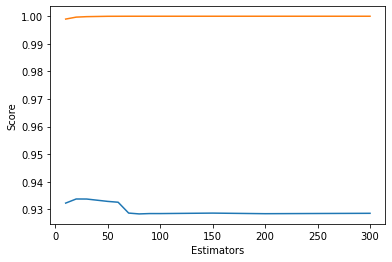

In [125]:
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)
%%time
train_scores = []
test_scores = []
#hyper param tuning 
start_time = time.time()
n_estimators=[10,20,30,50,60,70,80,90,100,150,200,300]
for estimator in n_estimators:
    
    xgboost  = xgb.XGBClassifier(learning_rate=0.1,n_estimators = estimator,max_depth= 50,random_state=314, silent=True, metric='None', n_jobs=4,
                         min_child_samples = 100,reg_alpha = 1e-1 , reg_lambda = 1e-1)
    xgboost.fit(x_train,y_train)  
    train_pred = xgboost.predict(x_train)
    train_f1_score = f1_score(y_train,train_pred)
    test_pred =xgboost.predict(x_test)
    test_f1_score = f1_score(y_test,test_pred)
    test_scores.append(train_f1_score)
    train_scores.append(test_f1_score)
    
    print('Estimators = ',estimator,'Train Score',train_f1_score,'test Score',test_f1_score)
print("Time Estimate : {0}".format(time.time() - start_time))
plt.plot(n_estimators,train_scores,label='Train Score')
plt.plot(n_estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')

Depth =  3 Train Score 0.9622414671421294 test Score 0.9256114560892156
Depth =  5 Train Score 0.9643581629341123 test Score 0.9273667830256129
Depth =  7 Train Score 0.9737640694617828 test Score 0.9331163065995857
Depth =  9 Train Score 0.9777988960106759 test Score 0.9334880776535134
Depth =  11 Train Score 0.9828739819757996 test Score 0.9339746023710078
Depth =  23 Train Score 0.9998601566245804 test Score 0.9331704543061143
Depth =  30 Train Score 0.9998501723018529 test Score 0.9338975201044167
Depth =  40 Train Score 0.9998501723018529 test Score 0.9337515525335243
Depth =  50 Train Score 0.9998501723018529 test Score 0.9337515525335243
Time Estimate : 289.776132106781


Text(0, 0.5, 'Score')

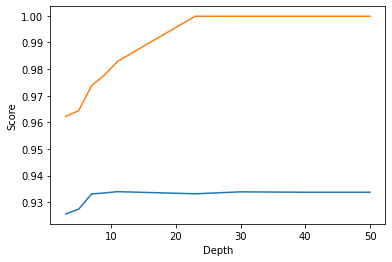

In [ ]:
train_scores = []
test_scores = []
#hyper param tuning 
start_time = time.time()
best_estimator = 30
max_depth = [3,5,7,9,11,23,30,40,50]
for depth in max_depth:
    
    xgboost  = xgb.XGBClassifier(learning_rate=0.1,n_estimators = best_estimator,max_depth= depth,random_state=314, silent=True, metric='None', n_jobs=4,
                         min_child_samples = 100,reg_alpha = 1e-1 , reg_lambda = 1e-1)
    
    xgboost.fit(x_train,y_train)
      
    train_pred = xgboost.predict(x_train)
    train_f1_score = f1_score(y_train,train_pred)
    test_pred =xgboost.predict(x_test)
    test_f1_score = f1_score(y_test,test_pred)
    test_scores.append(train_f1_score)
    train_scores.append(test_f1_score)
    
    print('Depth = ',depth,'Train Score',train_f1_score,'test Score',test_f1_score)
print("Time Estimate : {0}".format(time.time() - start_time))
plt.plot(max_depth,train_scores,label='Train Score')
plt.plot(max_depth,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')

In [ ]:
%%time
train_scores = []
test_scores = []
#hyper param tuning 
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
for lr in learning_rate:
    
    xgboost  = xgb.XGBClassifier(learning_rate=lr,n_estimators = 30,max_depth= 30,random_state=314, silent=True, metric='None', n_jobs=4,
                         min_child_samples = 20,reg_alpha = 0.1 , reg_lambda = 0.1)
    xgboost.fit(x_train, y_train)
    train_pred = xgboost.predict(x_train)
    train_f1_score = f1_score(y_train,train_pred)
    test_pred =xgboost.predict(x_test)
    test_f1_score = f1_score(y_test,test_pred)
    test_scores.append(train_f1_score)
    train_scores.append(test_f1_score)
    
    print('Learning Rate  = ',lr,'Train Score',train_f1_score,'test Score',test_f1_score)
plt.plot(learning_rate,train_scores,label='Train Score')
plt.plot(learning_rate,test_scores,label='Test Score')
plt.xlabel('learning_rate')
plt.ylabel('Score')

Learning Rate  =  0.0001 Train Score 0.992349901870469 test Score 0.9269912890894279
Learning Rate  =  0.001 Train Score 0.9932213911667818 test Score 0.9280756042485574
Learning Rate  =  0.01 Train Score 0.9973291720433334 test Score 0.930526404164218
Learning Rate  =  0.1 Train Score 0.9998501723018529 test Score 0.9338975201044167
Learning Rate  =  0.2 Train Score 0.9999900100898093 test Score 0.9290862590095327


 Alpha  =  0 Train Score 0.9998801342496404 test Score 0.9336027106088346
 Alpha  =  0.1 Train Score 0.9998501723018529 test Score 0.9338975201044167
 Alpha  =  0.5 Train Score 0.9996803643846016 test Score 0.9332574895714827
 Alpha  =  1 Train Score 0.9990308237997703 test Score 0.9333192878963447
 Alpha  =  2 Train Score 0.9964370070859523 test Score 0.933423226023934
CPU times: user 8min 9s, sys: 3.17 s, total: 8min 12s
Wall time: 4min 18s


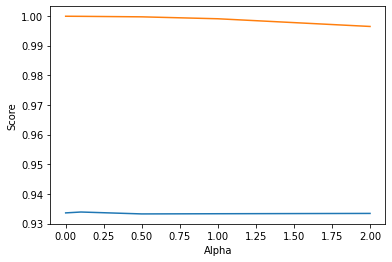

In [84]:
%%time
train_scores = []
test_scores = []
best_learning_rate = 0.1
max_depth = 30
best_estimators = 30
#hyper param tuning 
reg_alpha =  [0, 1e-1, 0.5,1, 2]
for alpha in reg_alpha:
    
    xgboost  = xgb.XGBClassifier(learning_rate=best_learning_rate,n_estimators =best_estimators ,max_depth= max_depth,random_state=314, silent=True, metric='None', n_jobs=4,
                         min_child_samples = 20,reg_alpha = alpha , reg_lambda = 0.1)
    xgboost.fit(x_train, y_train)
    train_pred = xgboost.predict(x_train)
    train_f1_score = f1_score(y_train,train_pred)
    test_pred =xgboost.predict(x_test)
    test_f1_score = f1_score(y_test,test_pred)
    test_scores.append(train_f1_score)
    train_scores.append(test_f1_score)
    
    print(' Alpha  = ',alpha,'Train Score',train_f1_score,'test Score',test_f1_score)
plt.plot(reg_alpha,train_scores,label='Train Score')
plt.plot(reg_alpha,test_scores,label='Test Score')
plt.xlabel('Alpha')
plt.ylabel('Score')

 Min_leaf_samples  =  1.0 Train Score 0.9784861364096336 test Score 0.9336850991979739
 Min_leaf_samples  =  12.0 Train Score 0.9784861364096336 test Score 0.9336850991979739
 Min_leaf_samples  =  23.0 Train Score 0.9784861364096336 test Score 0.9336850991979739
 Min_leaf_samples  =  34.0 Train Score 0.9784861364096336 test Score 0.9336850991979739
 Min_leaf_samples  =  45.0 Train Score 0.9784861364096336 test Score 0.9336850991979739
 Min_leaf_samples  =  56.0 Train Score 0.9784861364096336 test Score 0.9336850991979739
 Min_leaf_samples  =  67.0 Train Score 0.9784861364096336 test Score 0.9336850991979739
 Min_leaf_samples  =  78.0 Train Score 0.9784861364096336 test Score 0.9336850991979739
 Min_leaf_samples  =  89.0 Train Score 0.9784861364096336 test Score 0.9336850991979739
 Min_leaf_samples  =  100.0 Train Score 0.9784861364096336 test Score 0.9336850991979739
CPU times: user 13min 25s, sys: 4.07 s, total: 13min 29s
Wall time: 7min 3s


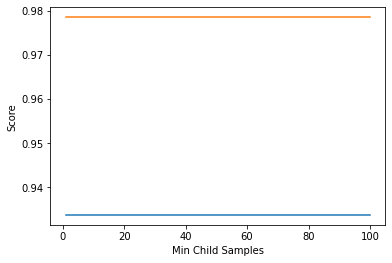

In [91]:
%%time
train_scores = []
test_scores = []
best_learning_rate = 0.1
max_depth = 30
best_estimators = 30
alpha = 0.1
#hyper param tuning 
min_child_samples =  np.linspace(1,100,num = 10)
for samples in min_child_samples:
    
    xgboost  = xgb.XGBClassifier(learning_rate=best_learning_rate,n_estimators =best_estimators ,max_depth= max_depth,random_state=314, silent=True, metric='None', n_jobs=4,
                         min_child_samples = samples,reg_alpha = alpha , reg_lambda = lamb)
    xgboost.fit(x_train, y_train)
    train_pred = xgboost.predict(x_train)
    train_f1_score = f1_score(y_train,train_pred)
    test_pred =xgboost.predict(x_test)
    test_f1_score = f1_score(y_test,test_pred)
    test_scores.append(train_f1_score)
    train_scores.append(test_f1_score)
    
    print(' Min_leaf_samples  = ',samples,'Train Score',train_f1_score,'test Score',test_f1_score)
plt.plot(min_child_samples,train_scores,label='Train Score')
plt.plot(min_child_samples,test_scores,label='Test Score')
plt.xlabel('Min Child Samples')
plt.ylabel('Score')

In [95]:
best_learning_rate = 0.1
max_depth = 30
best_estimators = 20
alpha = 0.1
#hyper param tuning 
best_min_child_samples =  100
lamb = 0.1

best_xg_boost_model_2 = xgb.XGBClassifier(learning_rate=best_learning_rate,n_estimators =best_estimators ,max_depth= max_depth,random_state=314, silent=True, metric='None', n_jobs=4,
                         min_child_samples = best_min_child_samples,reg_alpha = alpha , reg_lambda = lamb)
best_xg_boost_model_2.fit(x_train,y_train)
y_train_pred = best_xg_boost_model_2.predict(x_train)
y_test_pred = best_xg_boost_model_2.predict(x_test)
train_fl_score = f1_score(y_train,y_train_pred)
test_f1_score = f1_score(y_test,y_test_pred)
print("Training F1 Score : {0}".format(train_f1_score))
print("Test F1 Score : {0}".format(test_f1_score))

Training F1 Score : 0.9784861364096336
Test F1 Score : 0.9335099671965682


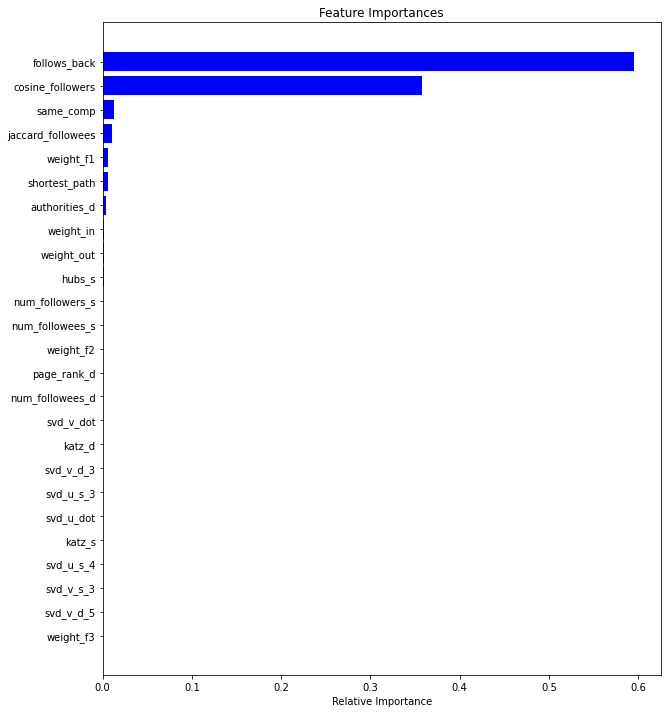

In [119]:
features = x_train.columns
importances = best_xg_boost_model_2.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Train confusion_matrix


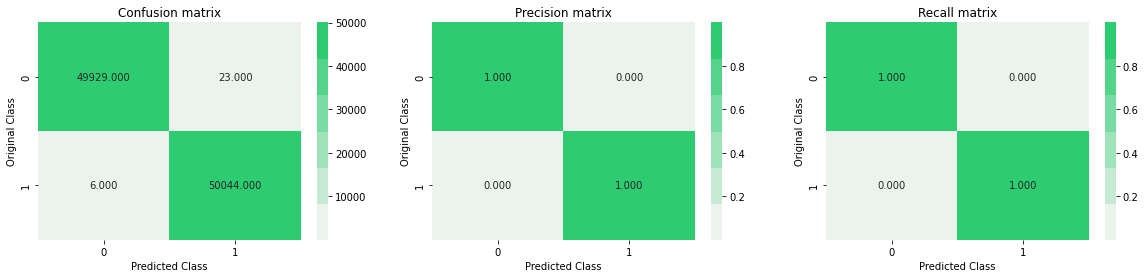

Test confusion_matrix


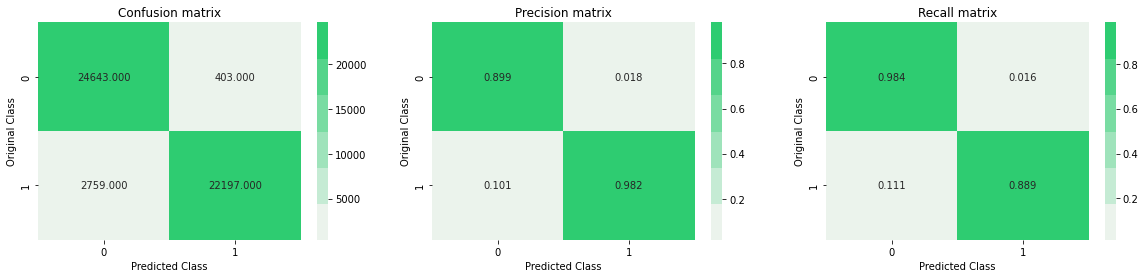

In [109]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

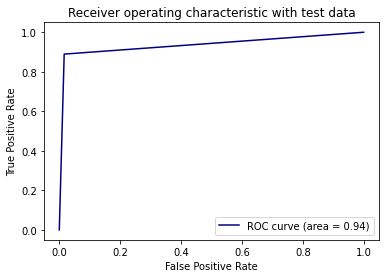

In [124]:
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

### Observation
1.To Build  Model GBDT algorithm Using XGB we got Auc Score as 0.94

2.As We see the Feature Important Follow Back and Cosine Followers is the most Important Features

3.We Observe XGBClaasifier and LGBClassifier,Both the Model we get AUC as 0.94,But in the Case LGB classifier Feature Importance is changes
LGB - (Shortest path,page Rank and weights more no of features are important).XGB Classifier (Follow Back and Cosine Follower those features consider as value)
rest of the feauture value is 0

4.We notice LGBClassifier model is fast as compared to XGBClassifier

# Hyperparam Tuning Using Random Search CV 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
xgboost = xgb.XGBClassifier()
prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[10,20,30,50,60,70,80,90,100,150,200,300,400,500],
     'max_depth':[3,5,10,20],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1],
    'reg_lambda': uniform(0, 1),
  'reg_alpha': uniform(0, 1)
}
random_search_param=RandomizedSearchCV(xgboost,param_distributions=prams,verbose=10,n_jobs=-1,)
random_search_param.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 14.6min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed: 19.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 24.3min
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed: 27.5min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed: 30.3min
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 34.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 35.9min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1...
                                        'n_estimators': [10, 20, 30, 50, 60, 70,
                                                         80, 90, 100, 150, 200,
                 

In [ ]:
print("Best Param of the XGBOOSE : {0}".format(random_search_param.best_params_))

Best Param of the XGBOOSE : {'colsample_bytree': 0.3, 'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 500, 'reg_alpha': 0.5821950113933088, 'reg_lambda': 0.6915228927272138, 'subsample': 1}


# HyperparamTuning Using Random Search CV

In [104]:
best_xg_boost = xgb.XGBClassifier(colsample_bytree= 0.3,learning_rate= 0.2 ,max_depth = 5,n_estimators = 500,reg_alpha= 0.5821950113933088,subsample = 1,reg_lamda = 0.0691)
best_xg_boost.fit(x_train,y_train)
xg_boost_train_pred = best_xg_boost.predict(x_train)
xg_boost_test_pred = best_xg_boost.predict(x_test)
train_fl_score = f1_score(y_train,xg_boost_train_pred)
test_f1_score = f1_score(y_test,xg_boost_test_pred)
print("Train_f1_score : {0}".format(train_f1_score))
print("Test_f1_score : {0}".format(test_f1_score))

Train_f1_score : 0.9784861364096336
Test_f1_score : 0.8996081845885938


Train confusion_matrix


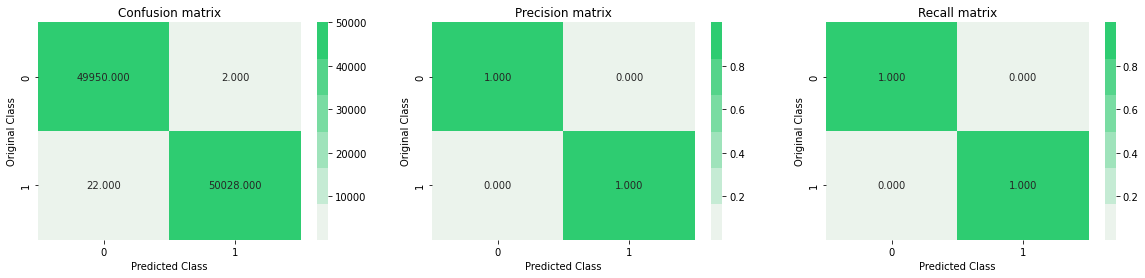

Test confusion_matrix


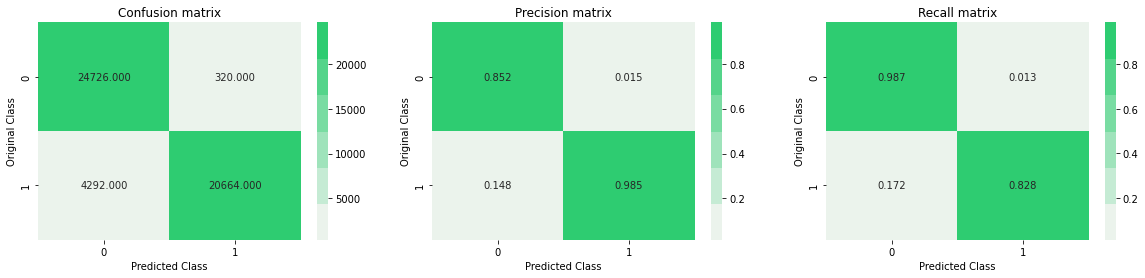

In [107]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,xg_boost_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,xg_boost_test_pred)

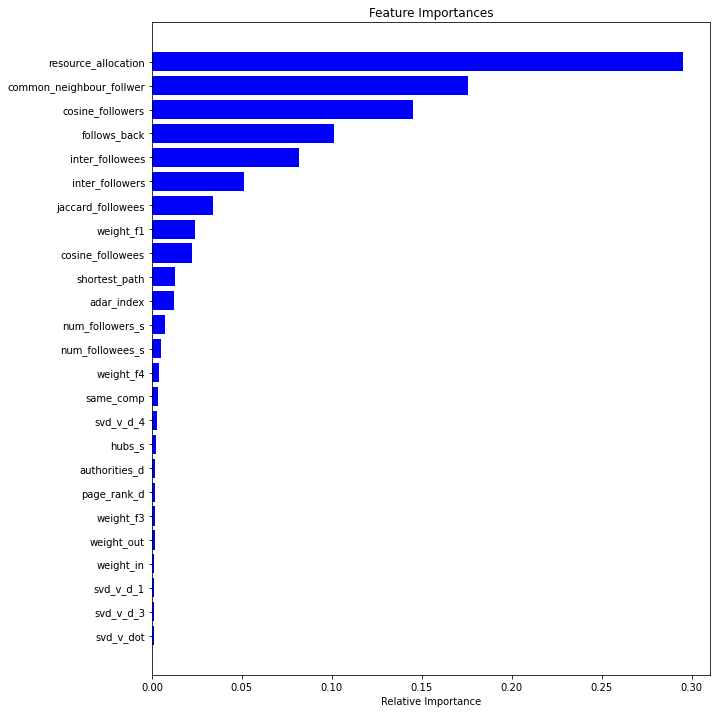

In [120]:
features = x_train.columns
importances = best_xg_boost.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

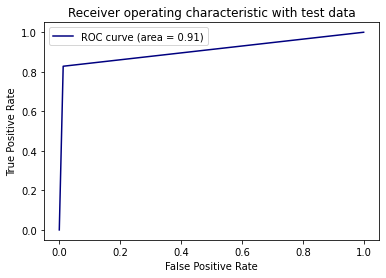

In [113]:
fpr,tpr,ths = roc_curve(y_test,xg_boost_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

## Observation:
1. After Tuning Hyperparameter using Random Search CV, train the XGBoost Model We got AUC Score is 91
2. Feature Importance Resouce Allocation and Common Neighbour Feature is the most Important Features

## Conclusion


In [3]:
from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
table = PrettyTable([ "Model", 'F1 Score',"Test AUC"])
  
# Add rows
table.add_row([ "GBDT Classifier - LGBM", "0.935", "0.94"])
table.add_row([ "GBDT  Classifier - XGB", "0.933 ", "0.94"])
table.add_row([ "GBDT Classifier - XGB Random_search CV", "0.89", "0.91"])
print(table)

+----------------------------------------+----------+----------+
|                 Model                  | F1 Score | Test AUC |
+----------------------------------------+----------+----------+
|         GBDT Classifier - LGBM         |  0.935   |   0.94   |
|         GBDT  Classifier - XGB         |  0.933   |   0.94   |
| GBDT Classifier - XGB Random_search CV |   0.89   |   0.91   |
+----------------------------------------+----------+----------+


We train a Model using XGB and LGBM classifier Both the Model Perform good.LGBM Classifier is 5 times Faster than XGB Classifier 